# $\pi/4$ rotation in the $xy$ plane


Rotate a point source in the $xy$ plane by $\pi/4$ and project.

Compute the same thing analytically and compare.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from simplecryoem.utils import spherical_volume, volume_fourier
from simplecryoem.forwardmodel import interpolate, project_spatial
from simplecryoem.forwardmodel.projection import rotate_z0

In [2]:
%load_ext autoreload
%autoreload 2

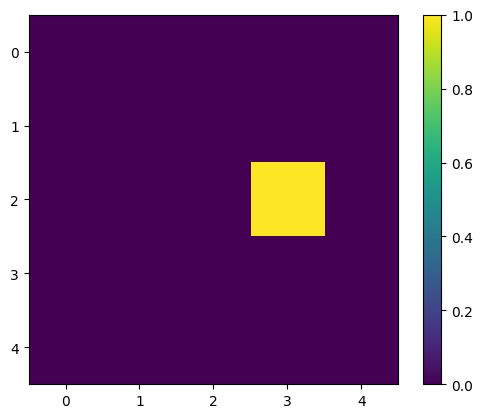

In [3]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
pixel_size = dimensions[0] / shape[0]
radius = 1 / (2 * nx)
centre = np.array([0.2, 0, 0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)
plt.imshow(v[:, :, 2])
plt.colorbar()

angles = np.array([0, 0, -np.pi / 4])

In [4]:
v.shape

(5, 5, 5)

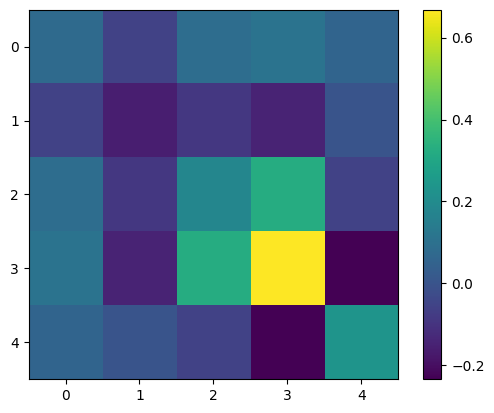

In [5]:
v_proj = project_spatial(v, angles, pixel_size, [0, 0], "nn", pfac=1)

plt.imshow(v_proj)
plt.colorbar()

In [6]:
point_idx = np.array(list(np.where(v == 1))).flatten()
point_idx

array([2, 3, 2])

### Step by step inside the project function

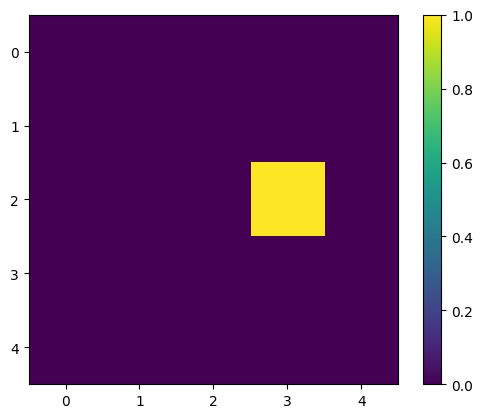

In [7]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
pixel_size = dimensions[0] / shape[0]
radius = 1 / (2 * nx)
centre = np.array([0.2, 0, 0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)
plt.imshow(v[:, :, 2])
plt.colorbar()

V, x_grid, _ = volume_fourier(v, pixel_size)

angles = np.array([0, 0, -np.pi / 4])

# plt.imshow(v[:,:,0]); plt.colorbar()

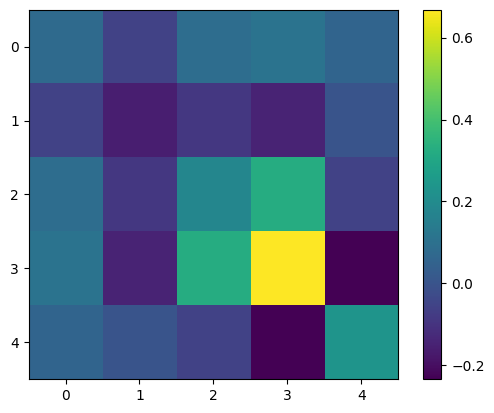

In [8]:
# Rotate coordinates
slice_coords = rotate_z0(x_grid, angles)

# slice_coords = slice_coords[:, 13:15]

# Interpolate and reshape
Vr0_flat = interpolate(slice_coords, x_grid, V, "nn")
Vr0 = Vr0_flat.reshape(nx, nx)

# Inverse Fourier transform
vr0 = np.real(np.fft.fftshift(np.fft.ifftn(Vr0)))

plt.imshow(vr0)
plt.colorbar()

In [9]:
# Compare with the above approach
np.sum(abs(vr0 - v_proj))

Array(6.46011022e-16, dtype=float64)

## Analytically

In [10]:
Ky = np.array(
    [
        [0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [-2, -2, -2, -2, -2],
        [-1, -1, -1, -1, -1],
    ],
    dtype=np.float64,
)
Kx = Ky.T

In [11]:
print(Kx)
print(Ky)

[[ 0.  1.  2. -2. -1.]
 [ 0.  1.  2. -2. -1.]
 [ 0.  1.  2. -2. -1.]
 [ 0.  1.  2. -2. -1.]
 [ 0.  1.  2. -2. -1.]]
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1.]]


In [12]:
# Construct Kxr and Kyr manually for np.pi/4 rotation and NN interpolation

Kxr = np.array(
    [
        [0, 1, 1, -1, -1],
        [-1, 0, 1, -2, -1],
        [-1, -1, 0, 2, -2],
        [1, 2, -2, 0, 1],
        [1, 1, 2, -1, 0],
    ]
)

Kyr = np.array(
    [
        [0, 1, 1, -1, -1],
        [1, 1, 2, -1, 0],
        [1, 2, -2, 0, 1],
        [-1, -1, 0, 2, -2],
        [-1, 0, 1, -2, -1],
    ]
)


print(Kxr)
print(Kyr)

[[ 0  1  1 -1 -1]
 [-1  0  1 -2 -1]
 [-1 -1  0  2 -2]
 [ 1  2 -2  0  1]
 [ 1  1  2 -1  0]]
[[ 0  1  1 -1 -1]
 [ 1  1  2 -1  0]
 [ 1  2 -2  0  1]
 [-1 -1  0  2 -2]
 [-1  0  1 -2 -1]]


In [13]:
# Find the indices (3,2) of the point mass after ifftshift (in the spatial domain)
xy_freq = np.array([0, 1, 2, -2, -1])
new_idx1 = np.fft.fftshift(xy_freq)[point_idx[0]]
new_idx2 = np.fft.fftshift(xy_freq)[point_idx[1]]

print(new_idx1)
print(new_idx2)

0
1


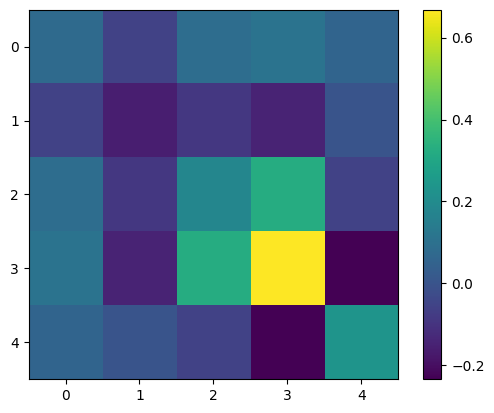

In [14]:
vr0_a = np.zeros([5, 5], dtype=np.complex128)
for i in range(5):
    for j in range(5):
        vr0_a[i, j] = (
            1
            / 25
            * np.sum(
                np.exp(
                    1j
                    * 2
                    * np.pi
                    / 5
                    *
                    # When ifftshifted, the indices (3, 2) become (1, 0)
                    (i * Kx + j * Ky - new_idx1 * Kxr - new_idx2 * Kyr)
                )
            )
        )

vr0_a = np.real(np.fft.fftshift(vr0_a))
plt.imshow(vr0_a)
plt.colorbar()

In [15]:
# Compare with the numerical result
np.max(abs(vr0_a - vr0))

1.1102230246251565e-16